# Ordinary Least Squares
### Основы статистики, <!-- БПМИ 2110 --> весна 2023, ДЗ 10

В этом ноутбуке вам предлагается воспроизвести некоторые функции из пакета ```statsmodels``` для линейной регрессии. Среди них - построение оценки МНК, доверительных интервалов, стандартных отклонений для параметров, а также критериев для проверки отсутствия эффекта (t-test, F-test).  

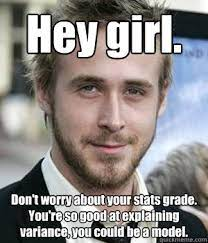

In [190]:
!pip install statsmodels munch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [191]:
%matplotlib inline

In [192]:
from typing import Union, Optional, Tuple, Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from munch import Munch
from scipy.stats import norm, t as student, f as fisher
import io
import re

np.random.seed(9876789)

Для начала напишем генератор данных для гауссовской модели:

$$ Y = Z\theta^* + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I_n)$$

$$Z = \begin{pmatrix}
        1 & x_{11} & \cdots & x_{1p} \\ 
        1 & x_{21} & \cdots & x_{2p} \\ 
        \vdots & \vdots & \ddots & \vdots \\
        1 & x_{n1} & \cdots & x_{np} \\ 
    \end{pmatrix} \in \mathbb{R}^{n \times (p+1)},\quad Y = \begin{pmatrix}Y_1 \\ \vdots \\ Y_n\end{pmatrix} \in \mathbb{R}^n$$

In [193]:
class GaussianModel:
    """Data generator for Gaussian model.
    
    Arguments:
        theta (np.ndarray): real parameters.
        sigma (float): noise standard deviation.
        
    """
    def __init__(self, theta: np.ndarray, sigma: float) -> None:
        self.theta = theta
        self.sigma = sigma
        
    def sample(self, X: np.ndarray)-> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Sample values.

        Args:
            X (np.ndarray): X matrix, shape [n, p]

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Z, Y, Z\theta
        """
        Z = sm.add_constant(X, prepend=True) # our model needs an intercept so we add a column of 1s:
        e = self.sigma * np.random.normal(size=X.shape[0])
        y_true = Z @ self.theta
        y = y_true + e
        
        return Z, y, y_true
        
    @staticmethod
    def train_test_split(Z: np.ndarray, y: np.ndarray, y_true: np.ndarray, test_size: float=0.5):
        arange = np.arange(Z.shape[0])
        test_ids = np.random.choice(arange, int(test_size * Z.shape[0]))
        test_ids = sorted(test_ids)
        train_ids = np.delete(arange, test_ids)
        Z_train, Z_test, y_train, y_test = Z[train_ids], Z[test_ids], y[train_ids], y[test_ids]
        y_true_train, y_true_test = y_true[train_ids], y_true[test_ids]
        
        return Z_train, Z_test, y_train, y_test, y_true_train, y_true_test

# OLS для полинома

Начнем с примера, когда мы хотим восстановить коэффициента полиннома степени $2$, но наблюдения мы получаем с гауссовским шумом:

$$Y_i = \theta^*_0 + \theta^*_1 x_i + \theta^*_2 x_i^2 + \epsilon_i, \quad \epsilon_i \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma^2)$$

In [194]:
nsample = 123
x = np.linspace(0, 10, nsample)
X = np.column_stack((x, x ** 2))
theta = np.array([1, 0.1, 10])
sigma = 128

np.random.seed(42)
Z, y, y_true = GaussianModel(theta, sigma).sample(X)
Z_train, Z_test, y_train, y_test, y_true_train, y_true_test = GaussianModel.train_test_split(Z, y, y_true)

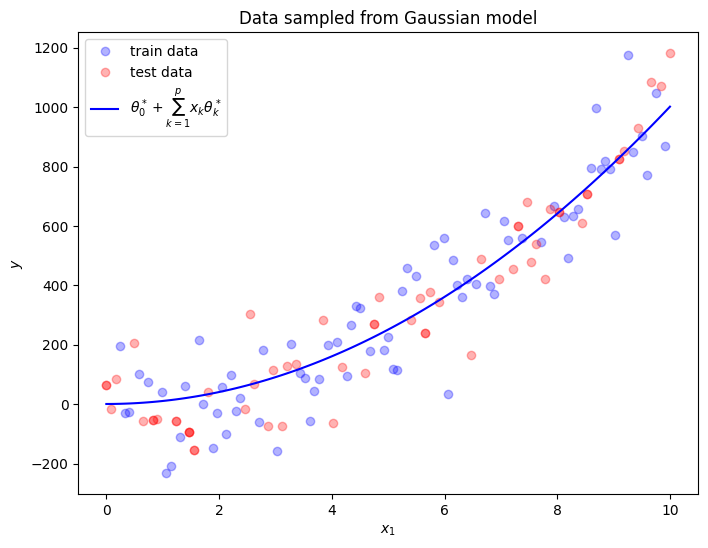

In [195]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(Z_train[:, 1], y_train, "bo", alpha=0.3, label="train data")
ax.plot(Z_test[:, 1], y_test, "ro", alpha=0.3, label="test data")
ax.plot(Z[:, 1], y_true, "b-", label=r"$\theta^*_0 + \sum_{k=1}^p x_k \theta^*_k$")
ax.legend(loc="best")
ax.set_title('Data sampled from Gaussian model')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$y$')
plt.show()

## Напоминание

Напомним величины, которыми мы оперируем в OLS. Начнем с понятий справедливых не только для гауссовской модели, но и для **модели случайного дизайна**. Оценка OLS имеет вид

$$\hat{\theta}_n = (Z^\top Z)^{+}Z^\top Y.$$

Нам бывает удобно определить матрицу Грамма (или выборочную матрицу ковариации):

$$\hat{G}_n = \frac{1}{n}Z^\top Z.$$

Несмещенная оценка дисперсии шума:

$$ \hat{\sigma}^2_{n} = \frac{1}{n - p - 1}\sum\limits_{i=1}^n(Y_i - \hat{Y}_i)^2,$$


$$ \hat{Y} = Z\hat{\theta}_n. $$

Коэффициент детерминации:

$$ R^2 = \frac{\sum\limits_{i=1}^n(\hat{Y}_i - \bar{Y}_n)^2}{\sum\limits_{i=1}^n(Y_i - \bar{Y}_n)^2},$$
$$\bar{Y}_n = \frac{1}{n}\sum\limits_{i=1}^n Y_i.$$ 


Стандартное отклонение параметров оценки OLS определим как такие $\widehat{se}_{n, k}$, что

$$\frac{\hat{\theta}_{n, k} - \theta^*_k}{\widehat{se}_{n, k}} \overset{d}{\rightarrow} \mathcal{N}(0, 1).$$

В этом ноутбуке вам предстоит вспомнить, как $\widehat{se}_{n, k}$ определяется через $\hat{G}_n$ и $\hat{\sigma}^2_n$.

Заметим, что для модели случайного дизайна этого знания нам достаточно для того чтобы строить ассимптотические доверительные интервалы на значения параметров $\theta^*$, а также чтобы строить асимптотические критерии для проверки отстутствия эффекта $\rm{H}_0: \theta^*_k = 0$ (t-test).

Для **гауссовской модели** мы дополнительно знаем следующее:

* Распределение $\frac{\hat{\theta}_{n, k} - \theta^*_k}{\widehat{se}_{n, k}}$ мы знаем не асимптотически, а точно (какое оно?). Соответственно и доверительные интервалы для параметров и критерии для $\rm{H}_0: \theta^*_k = 0$ (t-test) мы можем строить точные.
* Мы можем построить точные доверительные интервалы для $z^\top \theta^*$ (обозначаемый как $\rm{CI}(x)$) и для $z^\top \theta^* + \epsilon$ (обозначаемый как $\rm{PI}(x)$)
* Мы можем построить F test для проверки совместной гипотезы об отсутствии эффекта $\rm{R}\theta^* = 0$. 

Вспомним подробнее, как строится F test. С помощью  $R^c$, ортогонального дополнения к $R$, мы строим "сокращенную" модель и считаем для нее несмещенную оценку дисперсии $\tilde{\sigma}^2_{n}$. Заметим, что мы знаем, что $\hat{\sigma}^2_{n}$ и $\tilde{\sigma}^2_{n}$ расределены как $\chi^2$, но с разным числом степеней свободы (обозначим их $d_1$ и $d_2$).
Затем мы строим статистику 

$$ \hat{T}_n  = \frac{(\tilde{\sigma}^2_{n} d_2 - \hat{\sigma}^2_{n} d_1)/(d_2 - d_1)}{\hat{\sigma}^2_{n}}.$$

Утверждается, что рспределение $\hat{T}_n$ имеет распределение Фишера по построению. Параметры этого распределения определите самостоятельно)  


## Задание и критерии оценки

Весь код, который вам нужно восполнить находится в следующей ячейке. Ничего не меняйте в других ячейках.

1. (3 балла) Правильно реализованы функции (и результаты совпадают с ```statsmodels```)
   * ```gramm```
   * ```sigma```
   * ```_get_R2```
   * ```predict```
   * ```fit```
2. (3 балла) Привильно реализованы функции (и результаты совпадают с ```statsmodels```)
   * ```_get_param_se```
   * ```_get_ci```
   * ```_get_pi```
3. (4 балла) Правильно реализованы функции (и результаты совпадают с ```statsmodels```)
   * ```t_test```
   * ```f_test```
  

In [196]:
class OLS:
    """Interface for OLS estimate.
    
    Arguments:
        y (np.ndarray): observed values.
        Z (np.ndarray): observed data points.
        
    """
    _gramm: Optional[np.ndarray] = None
    _gramm_pinv: Optional[np.ndarray] = None
    _sigma: Optional[float] = None
    
    def __init__(self, y: np.array, Z: np.array):
        self.y = y
        self.Z = Z
        self.params = np.empty(self.Z.shape[1])

    @property
    def df(self) -> int:
        """Numder of degrees of freedom: n - p - 1

        Returns:
            int: numder of degrees of freedom.
        """
        return self.Z.shape[0] - self.Z.shape[1]
    
    @property
    def gramm(self) -> np.ndarray:
        """Gramm matrix.

        Returns:
            np.ndarray: Gramm matrix.
        """
        if self._gramm is None:
            self._gramm = (1/self.Z.shape[0]) * self.Z.T @ self.Z
        return self._gramm
    
    @property
    def gramm_pinv(self) -> np.ndarray:
        """Gramm matrix (pseudo)inverse.

        Returns:
            np.ndarray: Gramm matrix (pseudo)inverse.
        """
        if self._gramm_pinv is None:
            self._gramm_pinv = np.linalg.pinv(self.gramm)
        return self._gramm_pinv
    
    @property
    def sigma(self) -> float:
        """Estimate of the standard deviation of noise (sigma).

        Returns:
            int: sigma.
        """
        if self._sigma is None:
            y_hat = self.predict()
            self._sigma = 0
            for i in range(self.y.shape[0]):
                self._sigma += (self.y[i] - y_hat[i]) ** 2
            self._sigma /= self.df
            self._sigma = np.sqrt(self._sigma)
        return self._sigma
    
    def fit(self) -> Munch:
        """Fits the data.

        Returns:
            Munch: results.
        """
        n = self.Z.shape[0]
        
        self.params = (self.y @ self.Z) @ self.gramm_pinv / n
        
        results = Munch(
            params=self.params,
            rsquared=self._get_R2(),
            fittedvalues=self.predict(),
            stderr=self._get_params_se(),
            sigma=self.sigma,
        )
        return results
        
    def predict(self, Z: Optional[np.array]=None) -> np.array:
        """Makes prediction for the data.

        Args:
            z (Optional[np.array], optional): new data, shape [m, p + 1].

        Returns:
            np.array: prediction.
        """
        Z = Z if Z is not None else self.Z
        
        return Z @ self.params
     
    def _get_R2(self) -> float:
        """Computes determination coefficient.

        Returns:
            float: R2
        """
        y_hat = self.predict()
        y_mean = self.y.mean()
        a, b = 0, 0
        for i in range(self.y.shape[0]):
            a += (y_hat[i] - y_mean) ** 2
            b += (self.y[i] - y_mean) ** 2
        return a / b
    
    def _get_ci(self, z: Optional[np.ndarray] = None, alpha: float=0.05) -> np.ndarray:
        """Computes confidence interval for y^* - predictions of ideal model.

        Args:
            alpha (float, optional): significance level. Defaults to 0.05.

        Returns:
            np.ndarray: confidence interval, shape [2, n]
        """
        z = z if z is not None else self.Z
        # y_hat = self.predict(z)
        left_bound = np.zeros(z.shape[0])
        right_bound = np.zeros(z.shape[0])
        for i in range(z.shape[0]):
            left_bound[i] = z[i,:].T @ self.params - student.ppf(1-alpha/2, df=self.df)*np.sqrt(self.sigma**2 * z[i,:].T @ self.gramm_pinv/self.Z.shape[0] @ z[i,:])
            right_bound[i] = z[i,:].T @ self.params + student.ppf(1-alpha/2, df=self.df)*np.sqrt(self.sigma**2 * z[i,:].T @ self.gramm_pinv/self.Z.shape[0] @ z[i,:])

        obs_ci = np.stack([
            left_bound, right_bound])
        return obs_ci
    
    def _get_pi(self, z: Optional[np.ndarray] = None, alpha: float=0.05)-> np.ndarray:
        """Computes confidence interval for values y.

        Args:
            alpha (float, optional): significance level. Defaults to 0.05.

        Returns:
            np.ndarray: confidence interval, shape [2, n]
        """
        z = z if z is not None else self.Z
        # y_hat = self.predict(z)

        left_bound = np.zeros(Z.shape[0])
        right_bound = np.zeros(z.shape[0])
        for i in range(z.shape[0]):
            left_bound[i] = z[i,:].T @ self.params - student.ppf(1-alpha/2, df=self.df)*np.sqrt(self.sigma**2)*np.sqrt(1+ z[i,:].T @ self.gramm_pinv/self.Z.shape[0] @ z[i,:])
            right_bound[i] = z[i,:].T @ self.params + student.ppf(1-alpha/2, df=self.df)*np.sqrt(self.sigma**2)*np.sqrt(1+ z[i,:].T @ self.gramm_pinv/self.Z.shape[0] @ z[i,:])

        obs_pi = np.stack([
            left_bound, right_bound])
        return obs_pi
    
    def _get_params_se(self) -> np.ndarray:
        """Compute standard error of parameters

        Returns:
            np.ndarray: se
        """
        return np.sqrt(self.sigma ** 2 / self.Z.shape[0] * self.gramm_pinv.diagonal())
    
    def t_test(self, alpha: float = 0.05, use_t: bool = True) -> pd.DataFrame:
        """No-effect hypothesis t-test

        Args:
            alpha (float, optional): significance level. Defaults to 0.05.
            use_t (bool, optional): whether to use t-distribution for statistic. Defaults to True.

        Returns:
            pd.DataFrame: results
        """
        df = pd.DataFrame()
        
        df['coef'] = self.params
        df['std err'] = self._get_params_se()
        df['t'] = self.params / df['std err']
        
        if use_t:   # gaussian design
            df['P > |t|'] = 2 * student.sf(np.abs(df['t']), self.df)
            f = student.ppf(1-alpha/2,df=self.df)
        else:       # random design
            df['P > |t|'] = 2 * norm.sf(np.abs(df['t']))
            f = norm.ppf(1-alpha/2)
            
        df[f"[{(alpha / 2):.3f}"] = df.coef - f * df["std err"]
        df[f"{(1 - alpha / 2):.3f}]"] = df.coef + f * df["std err"]
        df.index = ['const'] + [f'x{k}' for k in range(1, self.Z.shape[1])]
        
        return df
        
    def f_test(self, ids: Sequence) -> Tuple[float, float]:
        """Joint no-effect hypothesis F-test.

        Args:
            ids (Sequence): indices of covariates supposed to be 0

        Returns:
            Tuple[float, float]: value of statistic and p-value
        """
        eye = np.eye(self.Z.shape[1])
        Rc = eye[list(set(np.arange(Z.shape[1])) - set(ids))] # orthogonal compliment.
        reduced_model = OLS(self.y, self.Z @ Rc.T)
        reduced_model.fit()
        sigma_r = reduced_model.sigma
        fval = (sigma_r**2*(self.Z.shape[0] - Rc.shape[0])-self.sigma**2*self.df)/(self.sigma**2*(self.Z.shape[0] - Rc.shape[0] - self.df))
        pval = fisher.sf(np.abs(fval), dfd=self.df, dfn=self.Z.shape[1] - Rc.shape[0])
        
        return  fval, pval
                

Получим OLS оценку и посчитаем некоторые характеристики:

In [197]:
model = OLS(y_train, Z_train)
results = model.fit()
print("Parameters: ", results.params)
print("R2: ", results.rsquared)
print("Sigma: ", results.sigma)
print("Sterr: ", results.stderr)

Parameters:  [-33.22705757   7.55979133   9.66412736]
R2:  0.8572795427573687
Sigma:  127.91124694028721
Sterr:  [47.375838   21.47853847  2.05292534]


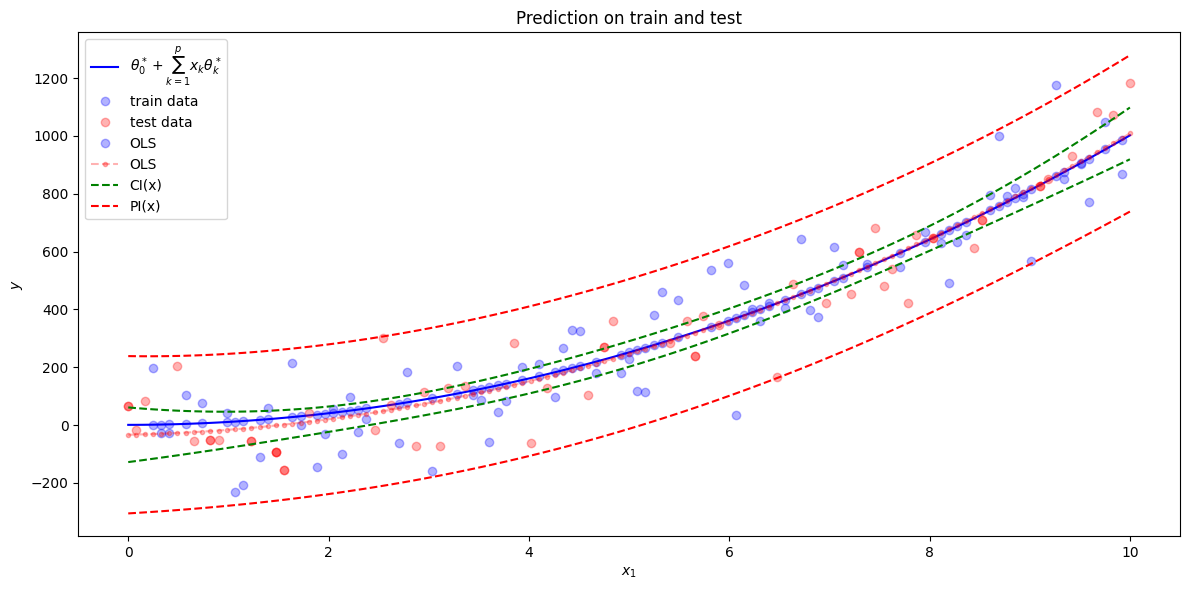

In [198]:
def plot_predictions(model, Z, Z_train, Z_test, y_train, y_test, y_true):
    fig, ax = plt.subplots(figsize=(12, 6))

    pred_ols = model.predict(Z)
    civ_l, civ_u = model._get_ci(Z)
    piv_l, piv_u = model._get_pi(Z)

    ax.plot(Z[:, 1], y_true, "b-", label=r"$\theta^*_0 + \sum_{k=1}^p x_k \theta^*_k$")
    ax.plot(Z_train[:, 1], y_train, "bo", alpha=0.3, label="train data")
    ax.plot(Z_test[:, 1], y_test, "ro", alpha=0.3, label="test data")
    ax.plot(Z_train[:, 1], y_true_train, "bo", alpha=0.3, label="OLS")
    ax.plot(Z[:, 1], pred_ols, "r--.", alpha=0.3, label="OLS")
    ax.plot(Z[:, 1], civ_u, "g--", label='CI(x)')
    ax.plot(Z[:, 1], civ_l, "g--")
    ax.plot(Z[:, 1], piv_u, "r--", label='PI(x)')
    ax.plot(Z[:, 1], piv_l, "r--")
    ax.set_title(f'Prediction on train and test')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$y$')

    ax.legend(loc="best")
    return fig, ax

fig, _ = plot_predictions(model, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

In [199]:
sm_model = sm.OLS(y_train, Z_train)
sm_results = sm_model.fit()
print(sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     213.2
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           9.64e-31
Time:                        09:47:20   Log-Likelihood:                -462.47
No. Observations:                  74   AIC:                             930.9
Df Residuals:                      71   BIC:                             937.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -33.2271     47.376     -0.701      0.4

Посмотрим, что сообщает нам эта табличка, конкретно в середине. 

* ```coef``` - это, очевидно, значения оценки OLS $\hat{\theta}_{n, k}$
* ```std err``` - это стандартное отклонение оценки, то есть в гауссовской модели такое $\widehat{se}_{n, k}$, что $\frac{(\hat{\theta}_{n, k} - \theta^*_k)}{\widehat{se}_{n, k}} \sim \mathcal{T}_{n - p - 1}$. В модели случайного дизайна это, соответственно, такое $\widehat{se}_{n, k}$, что $\frac{(\hat{\theta}_{n, k} - \theta^*_k)}{\widehat{se}_{n, k}} \overset{d}{\rightarrow} \mathcal{N}(0, 1)$.
* ```t``` - это значение статистики $T_{n, k}$ для проверки гипотезы о том, что $\hat{\theta}_{n, k} = 0$.
* ```P>|t|``` - это p-value для этого значения статистики. То есть наименьшее значение среди всех таких $\alpha$, что $P(T_{n, k} > |t|) \le \alpha$.
* Два последних столбца - это $0.025$ и $0.975$ квантили распределения $\hat{\theta}_{n, k}$, то есть симметричный $(1-0.05)$-доверительный интервал для $\theta^*_k$.

In [200]:
print("Parameters: ", sm_results.params)
print("R2: ", sm_results.rsquared)

Parameters:  [-33.22705757   7.55979133   9.66412736]
R2:  0.8572795427573615


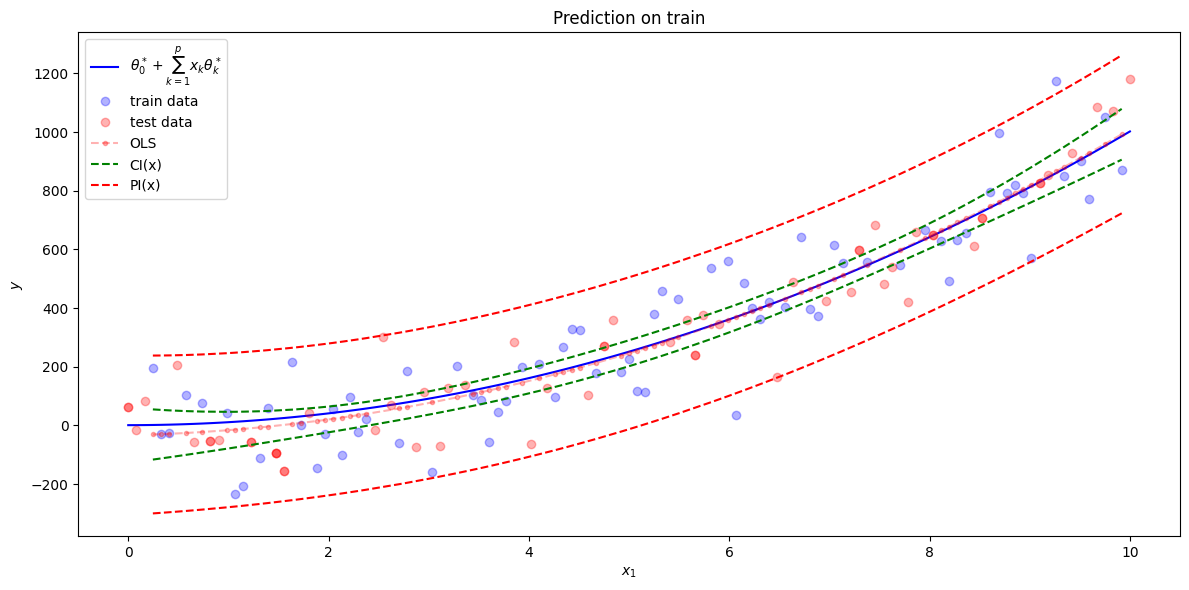

In [201]:
def plot_sm_predictions(results, Z, Z_train, Z_test, y_train, y_test, y_true):
    pred_ols = results.get_prediction()
    civ_l = pred_ols.summary_frame()["mean_ci_lower"]
    civ_u = pred_ols.summary_frame()["mean_ci_upper"]
    piv_l = pred_ols.summary_frame()["obs_ci_lower"]
    piv_u = pred_ols.summary_frame()["obs_ci_upper"]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(Z[:, 1], y_true, "b-", label=r"$\theta^*_0 + \sum_{k=1}^p x_k \theta^*_k$")
    ax.plot(Z_train[:, 1], y_train, "bo", alpha=0.3, label="train data")
    ax.plot(Z_test[:, 1], y_test, "ro", alpha=0.3, label="test data")
    ax.plot(Z_train[:, 1], results.fittedvalues, "r--.", alpha=0.3, label="OLS")
    ax.plot(Z_train[:, 1], civ_u, "g--", label='CI(x)')
    ax.plot(Z_train[:, 1], civ_l, "g--")
    ax.plot(Z_train[:, 1], piv_u, "r--", label='PI(x)')
    ax.plot(Z_train[:, 1], piv_l, "r--")
    ax.set_title(f'Prediction on train')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$y$')
    ax.legend(loc="best")
    
    return fig, ax

fig, _ = plot_sm_predictions(sm_results, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

Проверим, что оценка получена верно

In [202]:
assert np.isclose(model.params, sm_results.params).all()

# OLS для модели посложнее

In [203]:
nsample = 150
sigma = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x - 5) ** 2))
theta = [5.0, 0.5, 0.5, -0.02]

np.random.seed(42)
Z, y, y_true = GaussianModel(theta, sigma).sample(X)
Z_train, Z_test, y_train, y_test, y_true_train, y_true_test = GaussianModel.train_test_split(Z, y, y_true)

In [204]:
model = OLS(y_train, Z_train)
results = model.fit()
print("Parameters: ", results.params)
print("R2: ", results.rsquared)
print("Sigma: ", results.sigma)

Parameters:  [ 4.81332759  0.51981352  0.51533795 -0.02103936]
R2:  0.943313750745144
Sigma:  0.462273532950132


Посчитаем сами t-test для проверки отсутствия эффекта:

In [205]:
t_test_result = model.t_test()
t_test_result

,coef,std err,t,P > |t|,[0.025,0.975]
const,4.813328,0.116933,41.163290,1.009248e-59,4.580985,5.045670
x1,0.519814,0.017538,29.639303,6.809551e-48,0.484966,0.554661
x2,0.515338,0.069781,7.385124,7.784542e-11,0.376685,0.653990
x3,-0.021039,0.001534,-13.713629,1.150801e-23,-0.024088,-0.017991


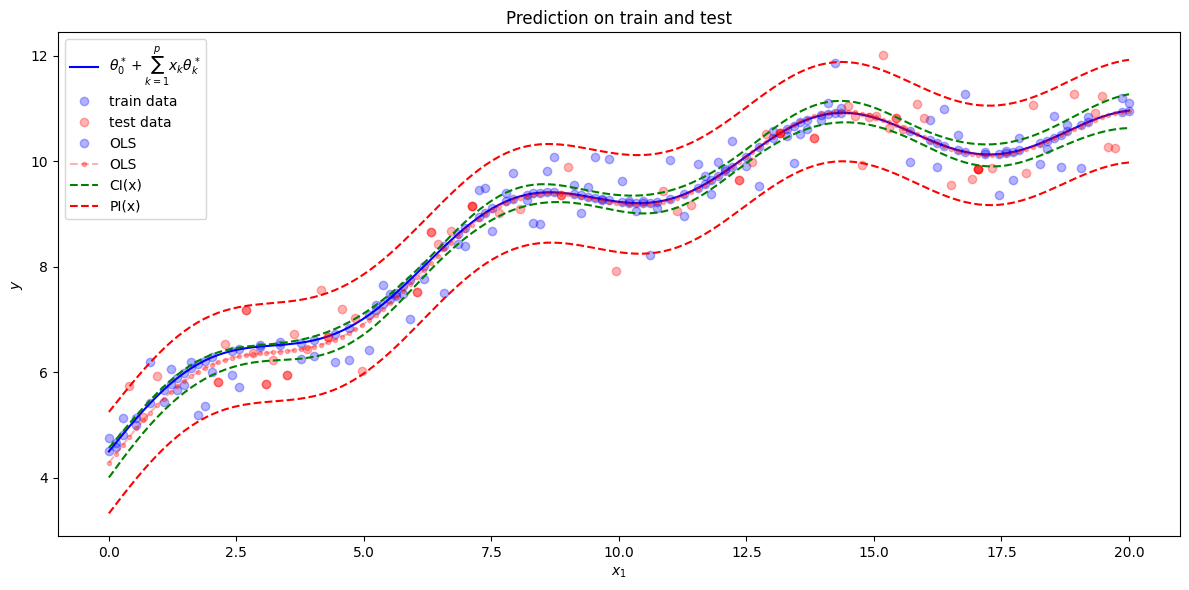

In [206]:
fig, _ = plot_predictions(model, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

In [207]:
sm_results = sm.OLS(y_train, Z_train).fit()
print(sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     493.7
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           2.50e-55
Time:                        09:47:22   Log-Likelihood:                -58.158
No. Observations:                  93   AIC:                             124.3
Df Residuals:                      89   BIC:                             134.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8133      0.117     41.163      0.0

In [208]:
print("Parameters: ", sm_results.params)
print("Standard errors: ", sm_results.bse)

Parameters:  [ 4.81332759  0.51981352  0.51533795 -0.02103936]
Standard errors:  [0.11693253 0.01753798 0.06978055 0.00153419]


Проверим, что результаты t-test'ов совпадают

In [209]:
sm_t_test_result = pd.read_csv(io.StringIO(u""+sm_results.summary().tables[1].as_csv()), header=0, index_col=0)
sm_t_test_result.columns = t_test_result.columns
sm_t_test_result.index = t_test_result.index

rnd = lambda x: f'{float(x):.3f}'

for col in t_test_result.columns:
   t_test_result[col] = t_test_result[col].apply(rnd)
for col in t_test_result.columns:
   sm_t_test_result[col] = sm_t_test_result[col].apply(rnd)
   
assert len(t_test_result.compare(sm_t_test_result)) == 0

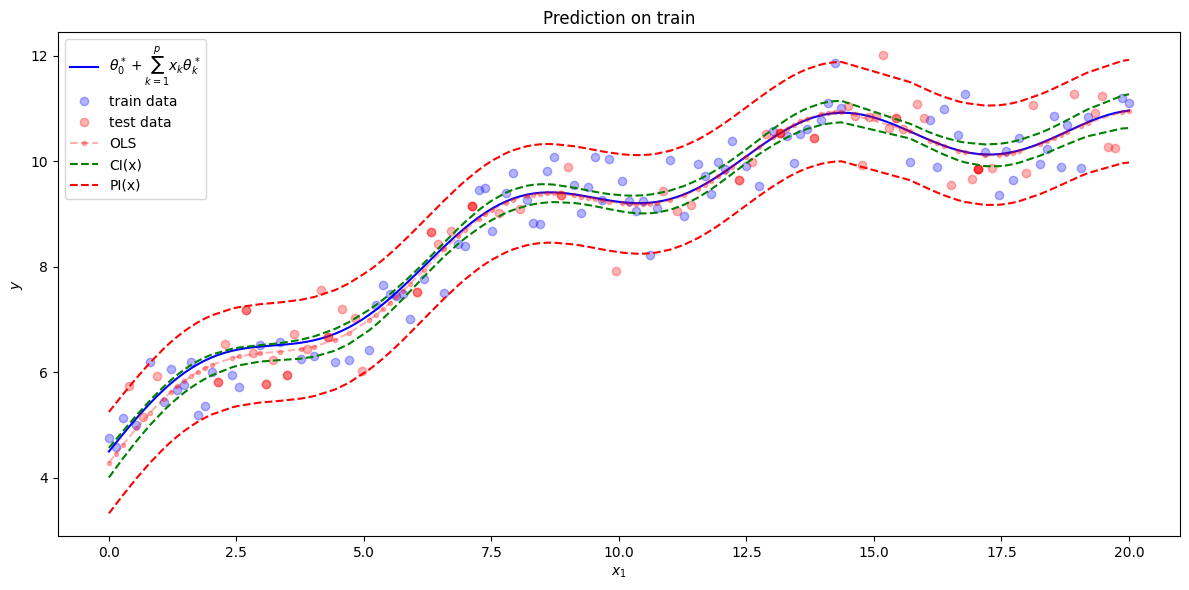

In [210]:
fig, _ = plot_sm_predictions(sm_results, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

## OLS с фиктивными переменными

Мы сгенерируем некоторый набор данных. Все данные будут делится на 3 группы, которые мы смодулируем с помощью этих фиктивных переменных.

In [211]:
nsample = 150
sigma = 1.
theta = [10, 1.0, 3, -3]

groups = np.zeros(nsample, int)
groups[int(0.4 * nsample):int(0.8 * nsample)] = 1
groups[int(0.8 * nsample):] = 2
# dummy = (groups[:,None] == np.unique(groups)).astype(float)

dummy = pd.get_dummies(groups).values
x = np.linspace(0, 20, nsample)
# drop reference category
X = np.column_stack((x, dummy[:, 1:]))

np.random.seed(42)
Z, y, y_true = GaussianModel(theta, sigma).sample(X)
Z_train, Z_test, y_train, y_test, y_true_train, y_true_test = GaussianModel.train_test_split(Z, y, y_true)

Посмотрим на получившиеся данные:

In [212]:
print(Z[:5, :])
print(y[:5])
print(groups)
print(dummy[:5, :])

[[1.         0.         0.         0.        ]
 [1.         0.13422819 0.         0.        ]
 [1.         0.26845638 0.         0.        ]
 [1.         0.40268456 0.         0.        ]
 [1.         0.53691275 0.         0.        ]]
[10.49671415  9.99596389 10.91614491 11.92571442 10.30275938]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [213]:
model = OLS(y_train, Z_train)
results = model.fit()
print("Parameters: ", results.params)
print("R2: ", results.rsquared)
print("Sigma: ", results.sigma)

Parameters:  [ 9.82169773  0.96928041  3.56651433 -2.26081646]
R2:  0.9761004504432483
Sigma:  0.9162248743758729


In [214]:
t_test_result = model.t_test()
t_test_result

,coef,std err,t,P > |t|,[0.025,0.975]
const,9.821698,0.233975,41.977516,1.921257e-60,9.356794,10.286601
x1,0.969280,0.045613,21.250227,1.258984e-36,0.878649,1.059912
x2,3.566514,0.399718,8.922578,5.433346e-14,2.772283,4.360745
x3,-2.260816,0.689153,-3.280573,1.480117e-03,-3.630149,-0.891484


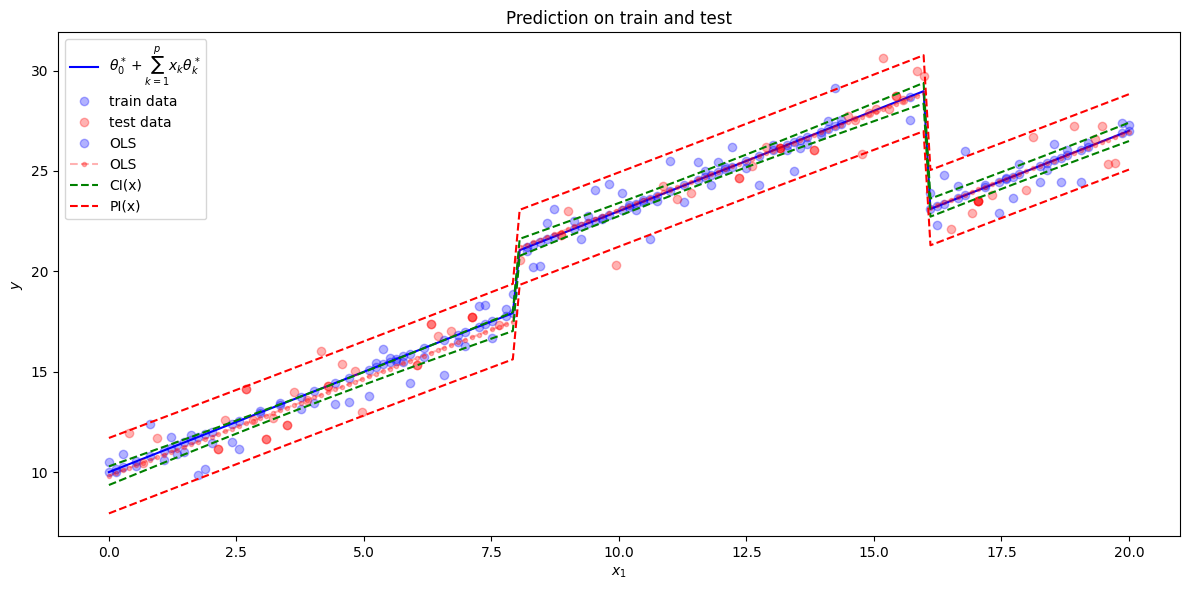

In [215]:
fig, _ = plot_predictions(model, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

In [216]:
sm_results = sm.OLS(y_train, Z_train).fit()
print(sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1212.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           5.17e-72
Time:                        09:47:24   Log-Likelihood:                -121.78
No. Observations:                  93   AIC:                             251.6
Df Residuals:                      89   BIC:                             261.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8217      0.234     41.978      0.0

In [217]:
sm_t_test_result = pd.read_csv(io.StringIO(u""+sm_results.summary().tables[1].as_csv()), header=0, index_col=0)
sm_t_test_result.columns = t_test_result.columns
sm_t_test_result.index = t_test_result.index

rnd = lambda x: f'{float(x):.0f}'

for col in t_test_result.columns:
   t_test_result[col] = t_test_result[col].apply(rnd)
for col in t_test_result.columns:
   sm_t_test_result[col] = sm_t_test_result[col].apply(rnd)
   
assert len(t_test_result.compare(sm_t_test_result)) == 0, t_test_result.compare(sm_t_test_result)

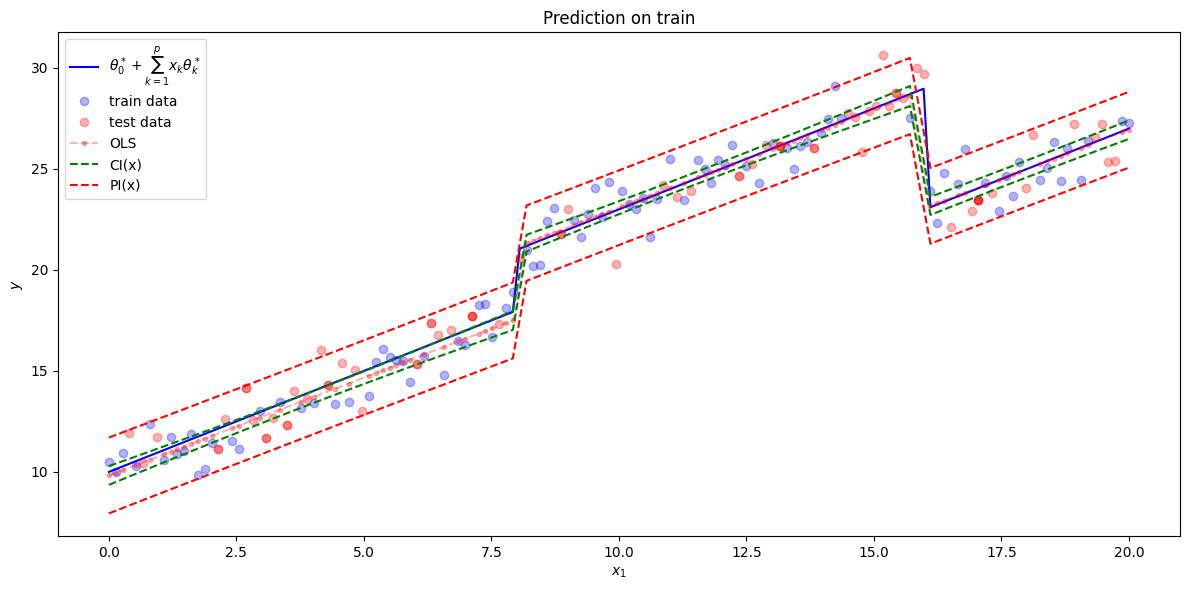

In [218]:
fig, _ = plot_sm_predictions(sm_results, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

# Совместная проверка отсутствия эффекта 

## F test

Мы хотим проверить гипотезу, что оба коэффициента, отвечающих фиктивным переменным, равняются 0, то есть $R \times \theta = 0$. F test говорит, что мы должны твердо и четко отвергнуть  базовую гипотезу о том, что для 3 групп константа одна и та же.

In [219]:
R = np.array([
        [0, 0, 1, 0], 
        [0, 0, 0, 1]
    ])
print(R)
print(sm_results.f_test(R))

[[0 0 1 0]
 [0 0 0 1]]
<F test: F=283.55007815410613, p=2.4699263950688015e-39, df_denom=89, df_num=2>


Можем использовать тест вот так:

In [220]:
sm_results.f_test("x2 = x3 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=283.5500781541065, p=2.469926395068689e-39, df_denom=89, df_num=2>

Получается очень маленькое значение p-value, что говорит о том, что гипотезу надо отвергнуть.

Посчитаем F test сами:

In [221]:
model = OLS(y_train, Z_train)
results = model.fit()
print("Parameters: ", results.params)
print("R2: ", results.rsquared)
print("Sigma: ", results.sigma)

fval, pval = model.f_test([2, 3])
print(fval, pval)

Parameters:  [ 9.82169773  0.96928041  3.56651433 -2.26081646]
R2:  0.9761004504432483
Sigma:  0.9162248743758729
283.55007815410676 2.469926395068599e-39


# Эффект при малом различии групп

Если мы сгенерируем данные с меньшим различием между группами, F test больше не может отвергнуть базовую гипотезу:

In [222]:
theta = [10, 1.0, 0.3, -0.0]

np.random.seed(42)
Z, y, y_true = GaussianModel(theta, sigma).sample(X)
Z_train, Z_test, y_train, y_test, y_true_train, y_true_test = GaussianModel.train_test_split(Z, y, y_true)

sm_results = sm.OLS(y_train, Z_train).fit()
print(sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1262.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           8.73e-73
Time:                        09:47:25   Log-Likelihood:                -121.78
No. Observations:                  93   AIC:                             251.6
Df Residuals:                      89   BIC:                             261.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8217      0.234     41.978      0.0

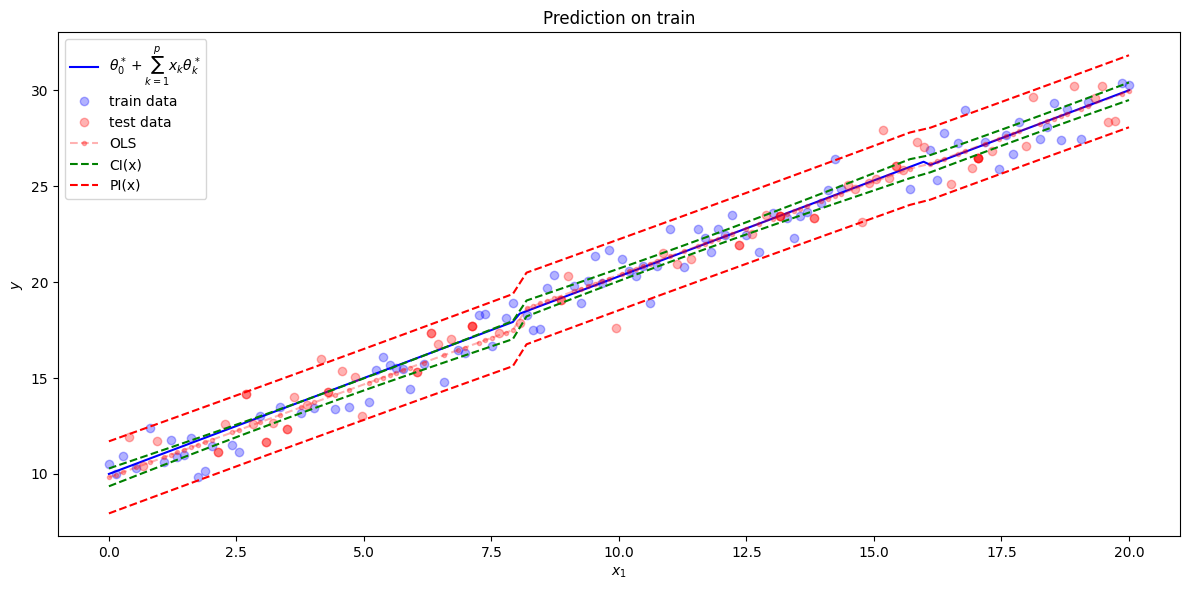

In [223]:
fig, _ = plot_sm_predictions(sm_results, Z, Z_train, Z_test, y_train, y_test, y_true)
fig.tight_layout()

In [224]:
print(sm_results.f_test(R))

<F test: F=3.6558720519385415, p=0.029793997701683044, df_denom=89, df_num=2>


In [225]:
print(sm_results.f_test("x2 = x3 = 0"))

<F test: F=3.6558720519385424, p=0.029793997701683044, df_denom=89, df_num=2>


Теперь значение p-value большое ($> 0.05$), то есть мы не можем отвергнуть гипотезу.

In [226]:
sm_fval, sm_pval = list(map(lambda x: f'{float(x):.3f}', re.findall(r'[\d]*[.][\d]+', sm_results.f_test(R).summary())))

In [227]:
model = OLS(y_train, Z_train)
results = model.fit()
print("Parameters: ", results.params)
print("R2: ", results.rsquared)
print("Sigma: ", results.sigma)

fval, pval = model.f_test([2, 3])
print(fval, pval)

Parameters:  [9.82169773 0.96928041 0.86651433 0.73918354]
R2:  0.9770368974159309
Sigma:  0.9162248743758721
3.655872051938607 0.029793997701681292


Проверим, совпали ли значения F-статистики и p-value:

In [228]:
assert sm_fval == f'{fval:.3f}' and sm_pval == f'{pval:.3f}'